In [630]:
# -*- coding: utf-8 -*-
"""
Created on Wed Dec 14 16:41:44 2022

@author: bornf
"""

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression 
from collections import defaultdict
from IPython.core import display as ICD
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
pd.options.mode.chained_assignment = None 
from sklearn.model_selection import RepeatedStratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, auc,roc_curve
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

## World cup 2018 matches
totalRes = pd.read_csv('HistoricalResults.csv')



from datetime import datetime
wcData = totalRes[totalRes.tournament=="FIFA World Cup"]
wcData['date'] = pd.to_datetime(wcData['date'], format="%Y-%m-%d")
wcData = wcData[wcData.date>datetime(2018,6,13,0,0,0)]
wcData = wcData[wcData.date<datetime(2018,7,16,0,0,0)]
wcData = wcData.drop(['tournament','city','country','neutral'],axis=1)
wcData


# In[5]:


# WC 2018 group stage matches
wc_2018_group_stage=wcData[0:48]


# In[6]:


#
conditions = [
    wc_2018_group_stage['home_score'] > wc_2018_group_stage['away_score'], 
  wc_2018_group_stage['home_score'] < wc_2018_group_stage['away_score'],
  wc_2018_group_stage['home_score'] == wc_2018_group_stage['away_score']
  ]

choices = ["Win","Loss","Draw"]

wc_2018_group_stage['Result'] = np.select(conditions, choices, default=np.nan)


# In[7]:


wc_2018_group_stage.head(10)


# In[8]:


import requests
from bs4 import BeautifulSoup

url = 'https://www.soccerphile.com/soccerphile/news/fifa-rankings/fifa_jun.html'
req = requests.get(url)

soup = BeautifulSoup(req.text,'lxml')
table = soup.find('table')
ranking_2018 = pd.read_html(str(table))[0]
ranking_2018


# In[9]:


ranking2018_dict=dict(zip(ranking_2018.Team, ranking_2018.Ranking))


# In[10]:


# print(ranking_2018)
# 

# In[11]:


condition = [(wc_2018_group_stage.home_team == x) for x in ranking2018_dict.keys()]
values = ranking2018_dict.values()
wc_2018_group_stage['home_team_rankings'] = np.select(condition, values)

condition = [(wc_2018_group_stage.away_team == x) for x in ranking2018_dict.keys()]
values = ranking2018_dict.values()
wc_2018_group_stage['away_team_rankings'] = np.select(condition, values)


# In[12]:


wc_2018_group_stage


# In[13]:


condition = [(wc_2018_group_stage.home_team == x) for x in ranking2018_dict.keys()]
values = ranking2018_dict.values()
wc_2018_group_stage['home_team_rankings'] = np.select(condition, values)

condition = [(wc_2018_group_stage.away_team == x) for x in ranking2018_dict.keys()]
values = ranking2018_dict.values()
wc_2018_group_stage['away_team_rankings'] = np.select(condition, values)


# In[14]:


wc_2018_group_stage.loc[wc_2018_group_stage['home_team'] =="South Korea", 'home_team_rankings'] = 57
wc_2018_group_stage.loc[wc_2018_group_stage['away_team'] =="South Korea", 'away_team_rankings'] = 57


# In[15]:


wcQualiData = pd.read_csv('2018_WC_Quali.csv')


# In[16]:


wcQualiData.sort_values(by=['PPG'], ascending = False)


# In[17]:


ppg_qualifying_dict=dict(zip(wcQualiData.Team, wcQualiData.PPG))


# In[18]:


condition = [(wc_2018_group_stage.home_team == x) for x in ppg_qualifying_dict.keys()]
values = ppg_qualifying_dict.values()
wc_2018_group_stage['home_team_qualifying_ppg'] = np.select(condition, values)

condition = [(wc_2018_group_stage.away_team == x) for x in ppg_qualifying_dict.keys()]
values = ppg_qualifying_dict.values()
wc_2018_group_stage['away_team_qualifying_ppg'] = np.select(condition, values)


# In[19]:


totalRes.drop(['date','tournament','city','country','neutral'], axis=1, inplace=True)
totalRes.dropna(inplace=True)
totalRes_filter = pd.DataFrame(totalRes[['away_team','home_team','away_score','home_score']])
totalRes = totalRes.append(totalRes_filter)


# In[20]:


home = totalRes['home_score'].values
away = totalRes['away_score'].values
result = []
for i in range(totalRes.shape[0]):
    if home[i] == away[i]:
        result.append('Draw')
    elif home[i] > away[i]:
        result.append('Win')
    else:
        result.append('Loss')
totalRes['result'] = result


# In[21]:


win_pct_dict_home={}
win_pct_dict_away={}

for i in wc_2018_group_stage["home_team"].values:

  totalRes_team = totalRes[totalRes.home_team == i]
  win = totalRes_team['result'].value_counts()['Win']
  win_pct = win/totalRes_team.shape[0]
  win_pct_dict_home[i]=win_pct*100
for i in wc_2018_group_stage["away_team"].values:

  totalRes_team = totalRes[totalRes.home_team == i]
  win = totalRes_team['result'].value_counts()['Win']
  win_pct = win/totalRes_team.shape[0]
  win_pct_dict_away[i]=win_pct*100


# In[22]:


condition = [(wc_2018_group_stage.home_team == x) for x in win_pct_dict_home.keys()]
values = win_pct_dict_home.values()
wc_2018_group_stage['home_team_historical_win_pct'] = np.select(condition, values)

condition = [(wc_2018_group_stage.away_team == x) for x in win_pct_dict_away.keys()]
values = win_pct_dict_away.values()
wc_2018_group_stage['away_team_historical_win_pct'] = np.select(condition, values)


# In[23]:


wc_2018_group_stage=wc_2018_group_stage.drop(columns=["home_score","away_score","date"])


# In[24]:


wc_2018_group_stage_reverse=pd.DataFrame()
wc_2018_group_stage_reverse = wc_2018_group_stage.rename(columns = {'home_team':'away_team', 'away_team':'home_team','home_score':'away_score','away_score':'home_score','home_team_rankings':'away_team_rankings','away_team_rankings':'home_team_rankings','home_team_qualifying_ppg':'away_team_qualifying_ppg','away_team_qualifying_ppg':'home_team_qualifying_ppg','home_team_historical_win_pct':'away_team_historical_win_pct','away_team_historical_win_pct':'home_team_historical_win_pct'})


# In[25]:


for i in range(len(wc_2018_group_stage_reverse["Result"].values)):
  if wc_2018_group_stage_reverse["Result"].iloc[i] == "Win":
    wc_2018_group_stage_reverse["Result"].iloc[i]="Loss"
  elif wc_2018_group_stage_reverse["Result"].iloc[i] == "Loss":
    wc_2018_group_stage_reverse["Result"].iloc[i]="Win"


# In[26]:


wc_2018_group_stage_reverse
frames = [wc_2018_group_stage,wc_2018_group_stage_reverse, ]
wc_2018_group_stage=pd.concat(frames)


# In[27]:


wc_2018_group_stage = wc_2018_group_stage.reset_index(drop=True)

#wc_2018_group_stage_ohe=pd.get_dummies(wc_2018_group_stage, prefix=['home_team', 'away_team'], columns=['home_team', 'away_team'])


# In[29]:


X=wc_2018_group_stage.drop(columns=["Result","home_team","away_team"])
y=wc_2018_group_stage["Result"]

In [631]:
X

,home_team_rankings,away_team_rankings,home_team_qualifying_ppg,away_team_qualifying_ppg,home_team_historical_win_pct,away_team_historical_win_pct
0,70,67,2.060606,1.900000,61.093248,56.345178
1,45,14,2.166667,1.722222,64.444444,55.431755
2,41,37,2.000000,2.200000,61.858974,63.265306
3,4,10,2.700000,2.800000,58.260870,67.810026
4,7,36,2.300000,1.900000,58.134921,57.049180
...,...,...,...,...,...,...
91,23,6,1.600000,2.700000,60.060976,44.339623
92,8,61,2.500000,2.000000,51.604938,52.078240
93,16,27,1.500000,2.333333,49.275362,60.000000
94,21,55,2.333333,1.300000,56.172840,45.794393


In [632]:
y

0      Win
1     Loss
2     Loss
3     Draw
4      Win
      ... 
91    Draw
92     Win
93     Win
94     Win
95     Win
Name: Result, Length: 96, dtype: object

In [633]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.545926 using {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
0.506296 (0.135740) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.521481 (0.134101) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.517407 (0.143635) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.506296 (0.135740) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.521481 (0.141361) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.520741 (0.130518) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.520741 (0.146642) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.521111 (0.134236) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.534815 (0.132613) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.531111 (0.131011) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.534815 (0.133202) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.542222 (0.125229) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.524444 (0.134910) wi

In [634]:
ro16_count = {}
quarter_count = {}
semi_count = {}
final_count = {}
winner_count = {}
avg_accuracy = []
for epoch in range(100):
    
    logreg = LogisticRegression(max_iter=400)
    decisiontree=DecisionTreeClassifier()
    randomforest=RandomForestClassifier()
    
    log_model = logreg.fit(X, y)
    y_pred_log = log_model.predict(X)
    acc = avg_accuracy.append(log_model.score(X,y))
#     dt_model = decisiontree.fit(X,y)
#     y_pred_dt= dt_model.predict(X)
    # rf_model = randomforest.fit(X,y)
    # y_pred_rf= rf_model.predict(X)
    
    
    #y_pred = (y_pred == y_predict.max(axis=1)[:,None]).astype(int)
    
    
    # In[31]:
    
    
    wc_2018_group_stage[0:48].head()
    
    
    # In[32]:
    
    
    # print("Accuracy score for logistic regression {}".format(logreg.score(X[0:48], y[0:48])))
    # print("Accuracy score for decision trees {}".format(decisiontree.score(X[0:48], y[0:48])))
    # print("Accuracy score for random forest {}".format(randomforest.score(X[0:48], y[0:48])))
    
    
    # In[33]:
    
    
    #Printing predictions
    from collections import defaultdict
    total_points_pred = {key: 0 for key in wc_2018_group_stage["home_team"].values}
    for match,i in zip(wc_2018_group_stage.values[0:48],y_pred_log[0:48]):
      if i == "Win":
        # print(" Predicted winner between {} and {} is {}".format(match[0],match[1],match[0]))
        total_points_pred[match[0]]+=3
      elif i == "Loss":
        # print(" Predicted winner between {} and {} is {}".format(match[0],match[1],match[1]))
        total_points_pred[match[1]]+=3
      else:
        # print(" Predicted winner between {} and {} is {}".format(match[0],match[1],"Draw"))
        total_points_pred[match[0]]+=1
        total_points_pred[match[1]]+=1
    
    
    # 
    
    # In[34]:
    
    
    GroupA2018 = {"Russia":0,"Saudi Arabia":0,"Egypt":0,"Uruguay":0}
    GroupB2018 = {"Portugal":0,"Spain":0,"Morocco":0,"Iran":0}
    GroupC2018 = {"France":0,"Australia":0,"Peru":0,"Denmark":0}
    GroupD2018 = {"Argentina":0,"Iceland":0,"Croatia":0,"Nigeria":0}
    GroupE2018 = {"Costa Rica":0,"Serbia":0,"Brazil":0,"Switzerland":0}
    GroupF2018 = {"Germany":0,"Mexico":0,"Sweden":0,"South Korea":0}
    GroupG2018 = {"Belgium":0,"Panama":0,"Tunisia":0,"England":0}
    GroupH2018 = {"Colombia":0,"Japan":0,"Poland":0,"Senegal":0}
    
    for k,v in total_points_pred.items():
      if k in GroupA2018.keys():
        GroupA2018[k]=v
      elif k in GroupB2018.keys():
        GroupB2018[k]=v
      elif k in GroupC2018.keys():
        GroupC2018[k]=v
      elif k in GroupD2018.keys():
        GroupD2018[k]=v
      elif k in GroupE2018.keys():
        GroupE2018[k]=v
      elif k in GroupF2018.keys():
        GroupF2018[k]=v  
      elif k in GroupG2018.keys():
        GroupG2018[k]=v
      elif k in GroupH2018.keys():
        GroupH2018[k]=v
    
    
    # In[35]:
    
    
    GroupA2018=pd.DataFrame(sorted(GroupA2018.items(), key=lambda x: x[1], reverse=True), columns=['Team', 'Points'],)
    GroupB2018=pd.DataFrame(sorted(GroupB2018.items(), key=lambda x: x[1], reverse=True), columns=['Team', 'Points'])
    GroupC2018=pd.DataFrame(sorted(GroupC2018.items(), key=lambda x: x[1],reverse=True), columns=['Team', 'Points'])
    GroupD2018=pd.DataFrame(sorted(GroupD2018.items(), key=lambda x: x[1],reverse=True), columns=['Team', 'Points'])
    GroupE2018=pd.DataFrame(sorted(GroupE2018.items(), key=lambda x: x[1],reverse=True), columns=['Team', 'Points'])
    GroupF2018=pd.DataFrame(sorted(GroupF2018.items(), key=lambda x: x[1],reverse=True), columns=['Team', 'Points'])
    GroupG2018=pd.DataFrame(sorted(GroupG2018.items(), key=lambda x: x[1],reverse=True), columns=['Team', 'Points'])
    GroupH2018=pd.DataFrame(sorted(GroupH2018.items(), key=lambda x: x[1],reverse=True), columns=['Team', 'Points'])
    
    
    # In[36]:
    
    
    # GroupStage2018={"Group A":GroupA2018,"Group B":GroupB2018,"Group C":GroupC2018,"Group D":GroupD2018,"Group E":GroupE2018,"Group F":GroupF2018,"Group G":GroupG2018,"Group H":GroupH2018}
    # print("2018 WC group stage standings")
    # for k,v in GroupStage2018.items():
    #   print("----------------------")
    #   print("\t {}".format(k))
    #   ICD.display(v)
    
    
    
    # In[37]:
    
    
    #Round of 16
    wc_2018_ro16=wc_2018_group_stage
    wc_2018_ro16=wc_2018_ro16.iloc[0:0]
    
    
    # In[38]:
    
    
    wc_2018_ro16=wc_2018_ro16.append({'home_team':GroupA2018["Team"][0],'away_team':GroupB2018["Team"][1]}, ignore_index=True)
    wc_2018_ro16=wc_2018_ro16.append({'home_team':GroupA2018["Team"][1],'away_team':GroupB2018["Team"][0]}, ignore_index=True)
    
    wc_2018_ro16=wc_2018_ro16.append({'home_team':GroupC2018["Team"][0],'away_team':GroupD2018["Team"][1]}, ignore_index=True)
    wc_2018_ro16=wc_2018_ro16.append({'home_team':GroupC2018["Team"][1],'away_team':GroupD2018["Team"][0]}, ignore_index=True)
    
    wc_2018_ro16=wc_2018_ro16.append({'home_team':GroupE2018["Team"][0],'away_team':GroupF2018["Team"][1]}, ignore_index=True)
    wc_2018_ro16=wc_2018_ro16.append({'home_team':GroupE2018["Team"][1],'away_team':GroupF2018["Team"][0]}, ignore_index=True)
    
    wc_2018_ro16=wc_2018_ro16.append({'home_team':GroupG2018["Team"][0],'away_team':GroupH2018["Team"][1]}, ignore_index=True)
    wc_2018_ro16=wc_2018_ro16.append({'home_team':GroupG2018["Team"][1],'away_team':GroupH2018["Team"][0]}, ignore_index=True)
    
    for i in wc_2018_ro16['home_team'].values:
        if i in ro16_count.keys():
            ro16_count[i] += 1
        else:
            ro16_count[i] = 1
            
    for i in wc_2018_ro16['away_team'].values:
        if i in ro16_count.keys():
            ro16_count[i] += 1
        else:
            ro16_count[i] = 1
    # In[39]:
    
    condition = [(wc_2018_ro16.home_team == x) for x in ppg_qualifying_dict.keys()]
    values = ppg_qualifying_dict.values()
    wc_2018_ro16['home_team_qualifying_ppg'] = np.select(condition, values)
    
    condition = [(wc_2018_ro16.away_team == x) for x in ppg_qualifying_dict.keys()]
    values = ppg_qualifying_dict.values()
    wc_2018_ro16['away_team_qualifying_ppg'] = np.select(condition, values)
    
    
    # In[40]:
    
    
    condition = [(wc_2018_ro16.home_team == x) for x in ranking2018_dict.keys()]
    values = ranking2018_dict.values()
    wc_2018_ro16['home_team_rankings'] = np.select(condition, values)
    
    condition = [(wc_2018_ro16.away_team == x) for x in ranking2018_dict.keys()]
    values = ranking2018_dict.values()
    wc_2018_ro16['away_team_rankings'] = np.select(condition, values)
    
    
    # In[41]:
    
    
    condition = [(wc_2018_ro16.home_team == x) for x in win_pct_dict_home.keys()]
    values = win_pct_dict_home.values()
    wc_2018_ro16['home_team_historical_win_pct'] = np.select(condition, values)
    
    condition = [(wc_2018_ro16.away_team == x) for x in win_pct_dict_away.keys()]
    values = win_pct_dict_away.values()
    wc_2018_ro16['away_team_historical_win_pct'] = np.select(condition, values)
    
    
    # In[43]:
    
    
    # wc_2018_ro16_ohe=pd.get_dummies(wc_2018_ro16, prefix=['home_team', 'away_team'], columns=['home_team', 'away_team'])
    # cols = wc_2018_ro16_ohe.columns.union(wc_2018_group_stage_ohe.columns)
    # wc_2018_ro16_ohe = wc_2018_ro16_ohe.reindex(cols, axis=1, fill_value=0)
    X_16 = wc_2018_ro16.drop(columns=["Result","home_team","away_team"])
    
    y_pred_log = log_model.predict(X_16)
    
    # In[45]:
    
    
    import random
    quarter_final=[]
    for match,i in zip(wc_2018_ro16.values,y_pred_log):
      if i == "Win":
        # print(" Predicted winner between {} and {} is {}".format(match[0],match[1],match[0]))
        quarter_final.append(match[0])
      elif i == "Loss":
        # print(" Predicted winner between {} and {} is {}".format(match[0],match[1],match[1]))
        quarter_final.append(match[1])
      else:
        penalty=random.choice([match[0],match[1]])
        # print(" Predicted winner between {} and {} is {} through shootout ".format(match[0],match[1],penalty))
        quarter_final.append(penalty)
    
    
    
    # In[46]:
    
    
    wc_2018_qtr=wc_2018_ro16
    wc_2018_qtr=wc_2018_qtr.iloc[0:0]
    
    wc_2018_qtr=wc_2018_qtr.append({'home_team':quarter_final[0],'away_team':quarter_final[2]}, ignore_index=True)
    wc_2018_qtr=wc_2018_qtr.append({'home_team':quarter_final[4],'away_team':quarter_final[6]}, ignore_index=True)
    
    wc_2018_qtr=wc_2018_qtr.append({'home_team':quarter_final[1],'away_team':quarter_final[3]}, ignore_index=True)
    wc_2018_qtr=wc_2018_qtr.append({'home_team':quarter_final[5],'away_team':quarter_final[7]}, ignore_index=True)
    
    for i in wc_2018_qtr['home_team'].values:
        if i in quarter_count.keys():
            quarter_count[i] += 1
        else:
            quarter_count[i] = 1
            
    for i in wc_2018_qtr['away_team'].values:
        if i in quarter_count.keys():
            quarter_count[i] += 1
        else:
            quarter_count[i] = 1
    
    condition = [(wc_2018_qtr.home_team == x) for x in ppg_qualifying_dict.keys()]
    values = ppg_qualifying_dict.values()
    wc_2018_qtr['home_team_qualifying_ppg'] = np.select(condition, values)
    
    condition = [(wc_2018_qtr.away_team == x) for x in ppg_qualifying_dict.keys()]
    values = ppg_qualifying_dict.values()
    wc_2018_qtr['away_team_qualifying_ppg'] = np.select(condition, values)
    
    
    # In[49]:
    
    
    condition = [(wc_2018_qtr.home_team == x) for x in ranking2018_dict.keys()]
    values = ranking2018_dict.values()
    wc_2018_qtr['home_team_rankings'] = np.select(condition, values)
    
    condition = [(wc_2018_qtr.away_team == x) for x in ranking2018_dict.keys()]
    values = ranking2018_dict.values()
    wc_2018_qtr['away_team_rankings'] = np.select(condition, values)
    
    
    # In[50]:
    
    
    condition = [(wc_2018_qtr.home_team == x) for x in win_pct_dict_home.keys()]
    values = win_pct_dict_home.values()
    wc_2018_qtr['home_team_historical_win_pct'] = np.select(condition, values)
    
    condition = [(wc_2018_qtr.away_team == x) for x in win_pct_dict_away.keys()]
    values = win_pct_dict_away.values()
    wc_2018_qtr['away_team_historical_win_pct'] = np.select(condition, values)
    
    
    # In[51]:
    
    
    # wc_2018_qtr_ohe=pd.get_dummies(wc_2018_qtr, prefix=['home_team', 'away_team'], columns=['home_team', 'away_team'])
    # cols = wc_2018_qtr_ohe.columns.union(wc_2018_group_stage_ohe.columns)
    # wc_2018_qtr_ohe = wc_2018_qtr_ohe.reindex(cols, axis=1, fill_value=0)
    X_qtr = wc_2018_qtr.drop(columns=["Result","home_team","away_team"])
    
    y_pred_log = log_model.predict(X_qtr)
    
    
    # In[52]:
    
    
    semi_final=[]
    for match,i in zip(wc_2018_qtr.values,y_pred_log):
      if i == "Win":
        # print(" Predicted winner between {} and {} is {}".format(match[0],match[1],match[0]))
        semi_final.append(match[0])
      elif i == "Loss":
        # print(" Predicted winner between {} and {} is {}".format(match[0],match[1],match[1]))
        semi_final.append(match[1])
      else:
        penalty=random.choice([match[0],match[1]])
        # print(" Predicted winner between {} and {} is {} through shootout".format(match[0],match[1],penalty))
        semi_final.append(penalty)
    
    
    # In[53]:
    
    
    wc_2018_semi=wc_2018_qtr
    wc_2018_semi=wc_2018_semi.iloc[0:0]
    
    wc_2018_semi=wc_2018_semi.append({'home_team':semi_final[0],'away_team':semi_final[1]}, ignore_index=True)
    wc_2018_semi=wc_2018_semi.append({'home_team':semi_final[2],'away_team':semi_final[3]}, ignore_index=True)
    
    for i in wc_2018_semi['home_team'].values:
        if i in semi_count.keys():
            semi_count[i] += 1
        else:
            semi_count[i] = 1
            
    for i in wc_2018_semi['away_team'].values:
        if i in semi_count.keys():
            semi_count[i] += 1
        else:
            semi_count[i] = 1
    
    condition = [(wc_2018_semi.home_team == x) for x in ppg_qualifying_dict.keys()]
    values = ppg_qualifying_dict.values()
    wc_2018_semi['home_team_qualifying_ppg'] = np.select(condition, values)
    
    condition = [(wc_2018_semi.away_team == x) for x in ppg_qualifying_dict.keys()]
    values = ppg_qualifying_dict.values()
    wc_2018_semi['away_team_qualifying_ppg'] = np.select(condition, values)
    
    
    # In[55]:
    
    
    condition = [(wc_2018_semi.home_team == x) for x in ranking2018_dict.keys()]
    values = ranking2018_dict.values()
    wc_2018_semi['home_team_rankings'] = np.select(condition, values)
    
    condition = [(wc_2018_semi.away_team == x) for x in ranking2018_dict.keys()]
    values = ranking2018_dict.values()
    wc_2018_semi['away_team_rankings'] = np.select(condition, values)
    
    
    # In[56]:
    
    
    condition = [(wc_2018_semi.home_team == x) for x in win_pct_dict_home.keys()]
    values = win_pct_dict_home.values()
    wc_2018_semi['home_team_historical_win_pct'] = np.select(condition, values)
    
    condition = [(wc_2018_semi.away_team == x) for x in win_pct_dict_away.keys()]
    values = win_pct_dict_away.values()
    wc_2018_semi['away_team_historical_win_pct'] = np.select(condition, values)
    
    
    # In[57]:
    
    
    # wc_2018_semi_ohe=pd.get_dummies(wc_2018_semi, prefix=['home_team', 'away_team'], columns=['home_team', 'away_team'])
    # cols = wc_2018_semi_ohe.columns.union(wc_2018_group_stage_ohe.columns)
    # wc_2018_semi_ohe = wc_2018_semi_ohe.reindex(cols, axis=1, fill_value=0)
    X_semi = wc_2018_semi.drop(columns=["Result","home_team","away_team"])
    
    y_pred_log = log_model.predict(X_semi)
    
    
    # In[59]:
    
    
    final=[]
    for match,i in zip(wc_2018_semi.values,y_pred_log):
      if i == "Win":
        # print(" Predicted winner between {} and {} is {}".format(match[0],match[1],match[0]))
        final.append(match[0])
      elif i == "Loss":
        # print(" Predicted winner between {} and {} is {}".format(match[0],match[1],match[1]))
        final.append(match[1])
      else:
        penalty=random.choice([match[0],match[1]])
        # print(" Predicted winner between {} and {} is {} through shootout".format(match[0],match[1],penalty))
        final.append(penalty)
    
    
    # In[60]:
    
    
    wc_2018_final=wc_2018_semi
    wc_2018_final=wc_2018_final.iloc[0:0]
    
    wc_2018_final=wc_2018_final.append({'home_team':final[0],'away_team':final[1]}, ignore_index=True)
    
    for i in wc_2018_final['home_team'].values:
        if i in final_count.keys():
            final_count[i] += 1
        else:
            final_count[i] = 1
            
    for i in wc_2018_final['away_team'].values:
        if i in final_count.keys():
            final_count[i] += 1
        else:
            final_count[i] = 1
    
    # In[61]:
    
    
    condition = [(wc_2018_final.home_team == x) for x in ppg_qualifying_dict.keys()]
    values = ppg_qualifying_dict.values()
    wc_2018_final['home_team_qualifying_ppg'] = np.select(condition, values)
    
    condition = [(wc_2018_final.away_team == x) for x in ppg_qualifying_dict.keys()]
    values = ppg_qualifying_dict.values()
    wc_2018_final['away_team_qualifying_ppg'] = np.select(condition, values)
    
    
    # In[62]:
    
    
    condition = [(wc_2018_final.home_team == x) for x in ranking2018_dict.keys()]
    values = ranking2018_dict.values()
    wc_2018_final['home_team_rankings'] = np.select(condition, values)
    
    condition = [(wc_2018_final.away_team == x) for x in ranking2018_dict.keys()]
    values = ranking2018_dict.values()
    wc_2018_final['away_team_rankings'] = np.select(condition, values)
    
    
    # In[63]:
    
    
    condition = [(wc_2018_final.home_team == x) for x in win_pct_dict_home.keys()]
    values = win_pct_dict_home.values()
    wc_2018_final['home_team_historical_win_pct'] = np.select(condition, values)
    
    condition = [(wc_2018_final.away_team == x) for x in win_pct_dict_away.keys()]
    values = win_pct_dict_away.values()
    wc_2018_final['away_team_historical_win_pct'] = np.select(condition, values)
    
    X_final = wc_2018_final.drop(columns=["Result","home_team","away_team"])
    
    
    y_pred_log = log_model.predict(X_final)
    # In[65]:
    
    wc_winner = []
    for match,i in zip(wc_2018_final.values,y_pred_log):
      if i == "Win":
        # print(" Predicted winner between {} and {} is {}".format(match[0],match[1],match[0]))
        wc_winner.append(match[0])
      elif i == "Loss":
        # print(" Predicted winner between {} and {} is {}".format(match[0],match[1],match[1]))
        wc_winner.append(match[1])
      else:
        penalty=random.choice([match[0],match[1]])
        # print(" Predicted winner between {} and {} is {} through shootout".format(match[0],match[1],penalty))
        wc_winner.append(penalty)
        
    for i in wc_winner:
        if i in winner_count.keys():
            winner_count[i] += 1
        else:
            winner_count[i] = 1
            
np.mean(avg_accuracy)

0.5833333333333334

In [635]:
            
df_ro16 = pd.DataFrame(ro16_count.items(), columns=['Country','Appearances']).sort_values(by=['Appearances'], ascending=False)            
print("Round of 16 appearances:\n")
ICD.display(df_ro16)

df_quarter = pd.DataFrame(quarter_count.items(), columns=['Country','Appearances']).sort_values(by=['Appearances'], ascending=False)
print("Quarter final appearances:\n")
ICD.display(df_quarter)

df_semi = pd.DataFrame(semi_count.items(), columns=['Country','Appearances']).sort_values(by=['Appearances'], ascending=False)
print("Semi final appearances:\n") 
ICD.display(df_semi)

df_final = pd.DataFrame(final_count.items(), columns=['Country','Appearances']).sort_values(by=['Appearances'], ascending=False)
print("Final appearances:\n")
ICD.display(df_final)

df_winner = pd.DataFrame(winner_count.items(), columns=['Country','Appearances']).sort_values(by=['Appearances'], ascending=False)
print("World Cup wins:\n")
ICD.display(df_winner)

Round of 16 appearances:



,Country,Appearances
0,Uruguay,100
1,Egypt,100
2,France,100
3,Denmark,100
4,Brazil,100
5,Switzerland,100
6,Belgium,100
7,England,100
8,Spain,100
9,Portugal,100


Quarter final appearances:



,Country,Appearances
0,Spain,100
1,Brazil,100
2,Portugal,100
4,France,100
5,Belgium,100
6,Argentina,100
3,Switzerland,54
7,England,51
9,Poland,49
8,Germany,46


Semi final appearances:



,Country,Appearances
4,Argentina,54
7,Spain,54
2,Brazil,52
5,Belgium,48
0,France,46
1,Portugal,46
3,Switzerland,28
6,Poland,25
8,England,24
9,Germany,23


Final appearances:



,Country,Appearances
3,Argentina,49
4,Spain,34
5,Brazil,25
0,France,24
8,Portugal,23
2,Belgium,17
7,Germany,12
1,Switzerland,8
6,England,4
9,Poland,4


World Cup wins:



,Country,Appearances
2,Argentina,31
3,Brazil,18
4,Spain,13
9,Portugal,11
1,Belgium,6
5,France,6
6,Germany,6
0,Switzerland,5
7,England,2
8,Poland,2


In [636]:
sns.set_palette("CMRmap", n_colors=16)
plt.tight_layout()

<Figure size 640x480 with 0 Axes>

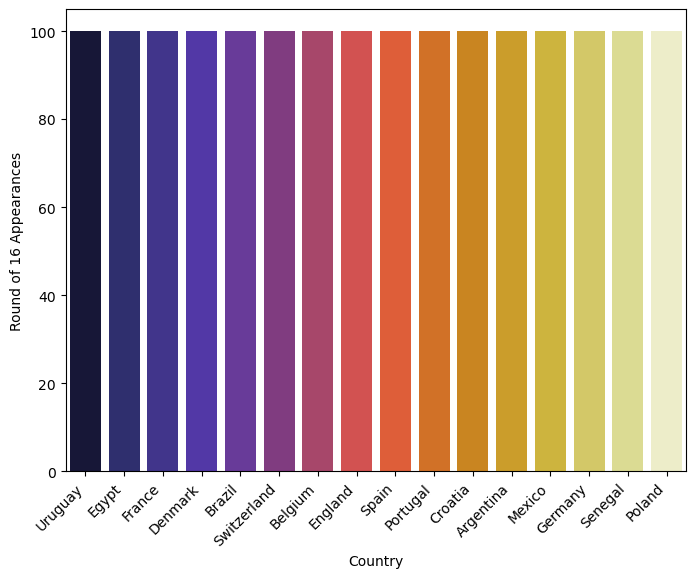

In [637]:
x = df_ro16['Country'].values
y = df_ro16['Appearances'].values
fig, ax = plt.subplots(figsize=(8,6))
plt.xticks(rotation=45, ha='right')
sns.barplot(x,y,ax=ax)
plt.ylabel('Round of 16 Appearances')
plt.xlabel('Country')
plt.savefig('LogReg2018Ro16', bbox_inches = "tight")
plt.show()

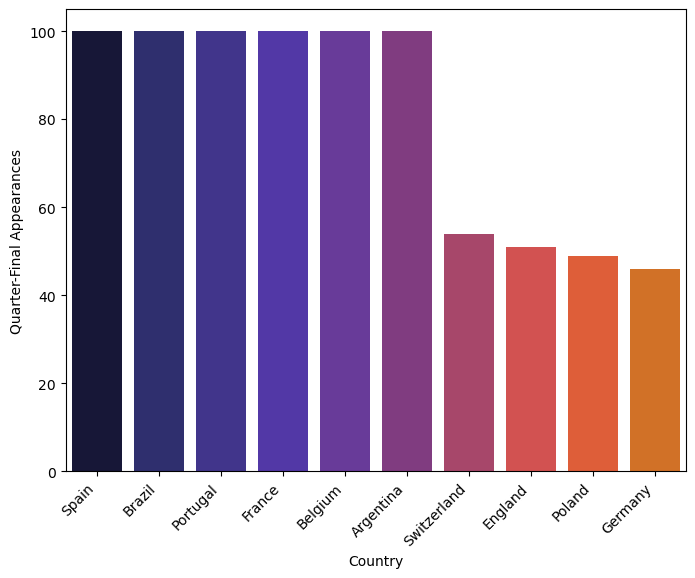

In [638]:
x = df_quarter['Country'].values
y = df_quarter['Appearances'].values
fig, ax = plt.subplots(figsize=(8,6))
plt.xticks(rotation=45, ha='right')
sns.barplot(x,y,ax=ax)
plt.ylabel('Quarter-Final Appearances')
plt.xlabel('Country')
plt.savefig('LogReg2018QF', bbox_inches = "tight")
plt.show()

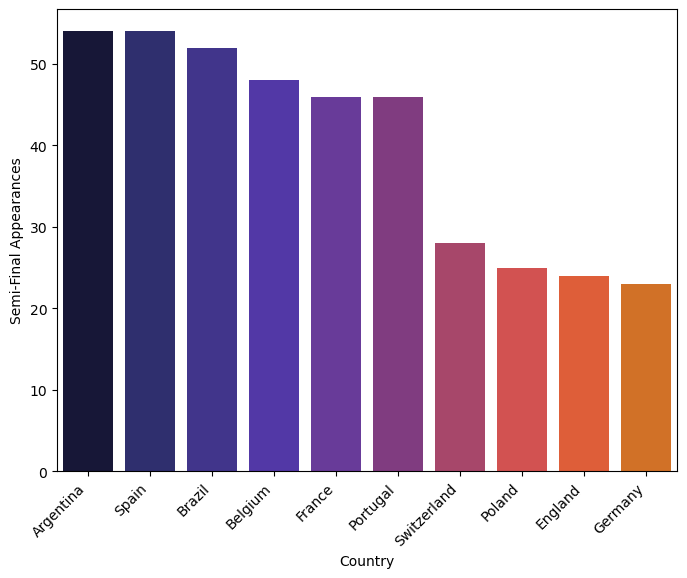

In [639]:
x = df_semi['Country'].values
y = df_semi['Appearances'].values
fig, ax = plt.subplots(figsize=(8,6))
plt.xticks(rotation=45, ha='right')
sns.barplot(x,y,ax=ax)
plt.ylabel('Semi-Final Appearances')
plt.xlabel('Country')
plt.savefig('LogReg2018SF', bbox_inches = "tight")
plt.show()

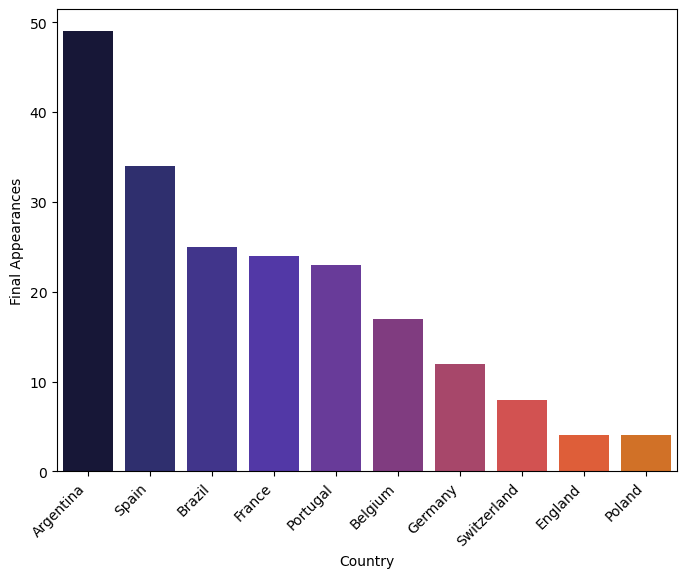

In [640]:
x = df_final['Country'].values
y = df_final['Appearances'].values
fig, ax = plt.subplots(figsize=(8,6))
plt.xticks(rotation=45, ha='right')
sns.barplot(x,y,ax=ax)
plt.ylabel('Final Appearances')
plt.xlabel('Country')
plt.savefig('LogReg2018Final', bbox_inches = "tight")
plt.show()

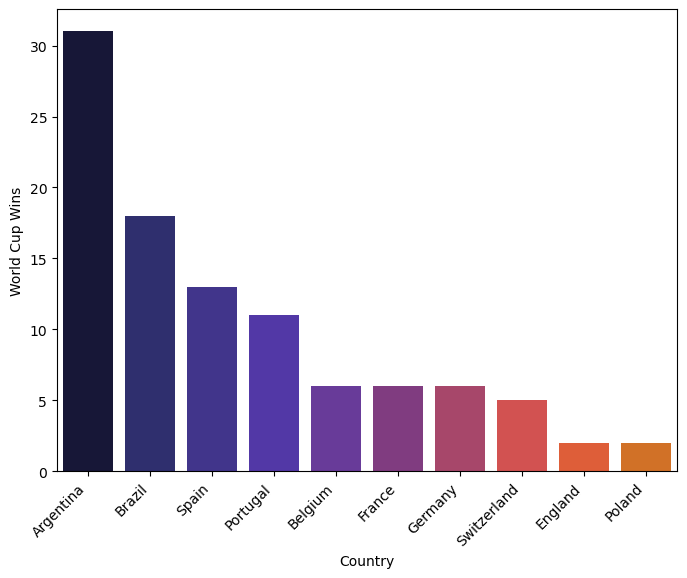

In [641]:
x = df_winner['Country'].values
y = df_winner['Appearances'].values
fig, ax = plt.subplots(figsize=(8,6))
plt.xticks(rotation=45, ha='right')
sns.barplot(x,y,ax=ax)
plt.ylabel('World Cup Wins')
plt.xlabel('Country')
plt.savefig('LogReg2018Winner', bbox_inches = "tight")
plt.show()

In [674]:


# World cup 2022 
totalRes = pd.read_csv('HistoricalResults.csv')
wcData = totalRes[totalRes.tournament=="FIFA World Cup"]
wcData['date'] = pd.to_datetime(wcData['date'], format="%Y-%m-%d")
wcData = wcData[wcData.date>datetime(2022,11,19,0,0,0)]
wcData = wcData[wcData.date<datetime(2022,12,3,0,0,0)]
wc_2022_group_stage = wcData.drop(['tournament','city','country','neutral'],axis=1)
wc_2022_group_stage


# In[67]:


conditions = [
    wc_2022_group_stage['home_score'] > wc_2022_group_stage['away_score'], 
  wc_2022_group_stage['home_score'] < wc_2022_group_stage['away_score'],
  wc_2022_group_stage['home_score'] == wc_2022_group_stage['away_score']
  ]

choices = ["Win","Loss","Draw"]

wc_2022_group_stage['Result'] = np.select(conditions, choices, default=np.nan)


# In[68]:


import requests
from bs4 import BeautifulSoup

url = 'https://www.soccerphile.com/fifa-rankings'
req = requests.get(url)

soup = BeautifulSoup(req.text,'lxml')
table = soup.find('table')
ranking_2022 = pd.read_html(str(table))[0]
ranking_2022


# In[69]:


ranking2022_dict=dict(zip(ranking_2022.Team, ranking_2022.Ranking))
ranking2022_dict


# In[70]:


condition = [(wc_2022_group_stage.home_team == x) for x in ranking2022_dict.keys()]
values = ranking2022_dict.values()
wc_2022_group_stage['home_team_rankings'] = np.select(condition, values)

condition = [(wc_2022_group_stage.away_team == x) for x in ranking2022_dict.keys()]
values = ranking2022_dict.values()
wc_2022_group_stage['away_team_rankings'] = np.select(condition, values)


# In[71]:


wc_2022_group_stage.loc[wc_2022_group_stage['home_team'] =="South Korea", 'home_team_rankings'] = 28
wc_2022_group_stage.loc[wc_2022_group_stage['away_team'] =="South Korea", 'away_team_rankings'] = 28
wc_2022_group_stage.loc[wc_2022_group_stage['home_team'] =="Netherlands", 'home_team_rankings'] = 8
wc_2022_group_stage.loc[wc_2022_group_stage['away_team'] =="Netherlands", 'away_team_rankings'] = 8
wc_2022_group_stage.loc[wc_2022_group_stage['home_team'] =="United States", 'home_team_rankings'] = 16
wc_2022_group_stage.loc[wc_2022_group_stage['away_team'] =="United States", 'away_team_rankings'] = 16
wc_2022_group_stage


# In[75]:


wc_2022_quali_data = pd.read_csv('2022_WC_Quali.csv')
wc_2022_quali_data.sort_values(by=['PPG'], ascending = False)[:10]


# In[76]:


ppg_qualifying_dict=dict(zip(wc_2022_quali_data.Team, wc_2022_quali_data.PPG))
ppg_qualifying_dict


# In[77]:


condition = [(wc_2022_group_stage.home_team == x) for x in ppg_qualifying_dict.keys()]
values = ppg_qualifying_dict.values()
wc_2022_group_stage['home_team_qualifying_ppg'] = np.select(condition, values)

condition = [(wc_2022_group_stage.away_team == x) for x in ppg_qualifying_dict.keys()]
values = ppg_qualifying_dict.values()
wc_2022_group_stage['away_team_qualifying_ppg'] = np.select(condition, values)

wc_2022_group_stage.head()


# In[78]:


totalRes.drop(['date','tournament','city','country','neutral'], axis=1, inplace=True)
totalRes.dropna(inplace=True)
totalRes_filter = pd.DataFrame(totalRes[['away_team','home_team','away_score','home_score']])
totalRes = totalRes.append(totalRes_filter)


# In[79]:


home = totalRes['home_score'].values
away = totalRes['away_score'].values
result = []
for i in range(totalRes.shape[0]):
    if home[i] == away[i]:
        result.append('Draw')
    elif home[i] > away[i]:
        result.append('Win')
    else:
        result.append('Loss')
totalRes['result'] = result


# In[80]:


win_pct_dict_home={}
win_pct_dict_away={}

for i in wc_2022_group_stage["home_team"].values:
    totalRes_team = totalRes[totalRes.home_team == i]
    win = totalRes_team['result'].value_counts()['Win']
    win_pct = win/totalRes_team.shape[0]
    win_pct_dict_home[i]=win_pct*100
for i in wc_2022_group_stage["away_team"].values:
    totalRes_team = totalRes[totalRes.home_team == i]
    win = totalRes_team['result'].value_counts()['Win']
    win_pct = win/totalRes_team.shape[0]
    win_pct_dict_away[i]=win_pct*100


# In[81]:


condition = [(wc_2022_group_stage.home_team == x) for x in win_pct_dict_home.keys()]
values = win_pct_dict_home.values()
wc_2022_group_stage['home_team_historical_win_pct'] = np.select(condition, values)

condition = [(wc_2022_group_stage.away_team == x) for x in win_pct_dict_away.keys()]
values = win_pct_dict_away.values()
wc_2022_group_stage['away_team_historical_win_pct'] = np.select(condition, values)
wc_2022_group_stage.head()


# In[82]:


wc_2022_group_stage=wc_2022_group_stage.drop(columns=["home_score","away_score","date"])
wc_2022_group_stage_reverse=pd.DataFrame()
wc_2022_group_stage_reverse = wc_2022_group_stage.rename(columns = {'home_team':'away_team', 'away_team':'home_team','home_score':'away_score','away_score':'home_score','home_team_rankings':'away_team_rankings','away_team_rankings':'home_team_rankings','home_team_qualifying_ppg':'away_team_qualifying_ppg','away_team_qualifying_ppg':'home_team_qualifying_ppg','home_team_historical_win_pct':'away_team_historical_win_pct','away_team_historical_win_pct':'home_team_historical_win_pct'})
for i in range(len(wc_2022_group_stage_reverse["Result"].values)):
    if wc_2022_group_stage_reverse["Result"].iloc[i] == "Win":
        wc_2022_group_stage_reverse["Result"].iloc[i]="Loss"
    elif wc_2022_group_stage_reverse["Result"].iloc[i] == "Loss":
        wc_2022_group_stage_reverse["Result"].iloc[i]="Win"


# In[83]:


frames = [wc_2022_group_stage,wc_2022_group_stage_reverse, ]
wc_2022_group_stage=pd.concat(frames)
wc_2022_group_stage.reset_index(drop=True, inplace=True)
wc_2022_group_stage


# In[84]:


X=wc_2022_group_stage.drop(columns=["Result","home_team","away_team"])
y=wc_2022_group_stage["Result"]



In [675]:
ro16_count = {}
quarter_count = {}
semi_count = {}
final_count = {}
winner_count = {}

for epoch in range(100):


    y_pred_log = log_model.predict(X)

#     y_pred_dt= dt_model.predict(X)
# 
#     y_pred_rf= rf_model.predict(X)


    # In[86]:


    wc_2022_group_stage[0:48]


    # In[87]:


    score = log_model.score(X[0:48], y[0:48])
    score


    # In[88]:


    from collections import defaultdict
    total_points_pred = {key: 0 for key in wc_2022_group_stage["home_team"].values}
    for match,i in zip(wc_2022_group_stage.values[0:48],y_pred_log[0:48]):
        if i == "Win":
#             print(" Predicted winner between {} and {} is {}".format(match[0],match[1],match[0]))
            total_points_pred[match[0]]+=3
        elif i == "Loss":
#             print(" Predicted winner between {} and {} is {}".format(match[0],match[1],match[1]))
            total_points_pred[match[1]]+=3
        else:
#             print(" Predicted winner between {} and {} is {}".format(match[0],match[1],"Draw"))
            total_points_pred[match[0]]+=1
            total_points_pred[match[1]]+=1


    # In[89]:


    GroupA2022 = {"Qatar":0,"Netherlands":0,"Ecuador":0,"Senegal":0}
    GroupB2022 = {"England":0,"United States":0,"Wales":0,"Iran":0}
    GroupC2022 = {"Argentina":0,"Poland":0,"Mexico":0,"Saudi Arabia":0}
    GroupD2022 = {"France":0,"Australia":0,"Tunisia":0,"Denmark":0}
    GroupE2022 = {"Costa Rica":0,"Japan":0,"Spain":0,"Germany":0}
    GroupF2022 = {"Morocco":0,"Croatia":0,"Belgium":0,"Canada":0}
    GroupG2022 = {"Brazil":0,"Switzerland":0,"Cameroon":0,"Serbia":0}
    GroupH2022 = {"Portugal":0,"South Korea":0,"Uruguay":0,"Ghana":0}

    for k,v in total_points_pred.items():
        if k in GroupA2022.keys():
            GroupA2022[k]=v
        elif k in GroupB2022.keys():
            GroupB2022[k]=v
        elif k in GroupC2022.keys():
            GroupC2022[k]=v
        elif k in GroupD2022.keys():
            GroupD2022[k]=v
        elif k in GroupE2022.keys():
            GroupE2022[k]=v
        elif k in GroupF2022.keys():
            GroupF2022[k]=v  
        elif k in GroupG2022.keys():
            GroupG2022[k]=v
        elif k in GroupH2022.keys():
            GroupH2022[k]=v


    # In[90]:


    GroupA2022=pd.DataFrame(sorted(GroupA2022.items(), key=lambda x: x[1], reverse=True), columns=['Team', 'Points'],)
    GroupB2022=pd.DataFrame(sorted(GroupB2022.items(), key=lambda x: x[1], reverse=True), columns=['Team', 'Points'])
    GroupC2022=pd.DataFrame(sorted(GroupC2022.items(), key=lambda x: x[1],reverse=True), columns=['Team', 'Points'])
    GroupD2022=pd.DataFrame(sorted(GroupD2022.items(), key=lambda x: x[1],reverse=True), columns=['Team', 'Points'])
    GroupE2022=pd.DataFrame(sorted(GroupE2022.items(), key=lambda x: x[1],reverse=True), columns=['Team', 'Points'])
    GroupF2022=pd.DataFrame(sorted(GroupF2022.items(), key=lambda x: x[1],reverse=True), columns=['Team', 'Points'])
    GroupG2022=pd.DataFrame(sorted(GroupG2022.items(), key=lambda x: x[1],reverse=True), columns=['Team', 'Points'])
    GroupH2022=pd.DataFrame(sorted(GroupH2022.items(), key=lambda x: x[1],reverse=True), columns=['Team', 'Points'])


    # In[91]:


#     GroupStage2022={"Group A":GroupA2022,"Group B":GroupB2022,"Group C":GroupC2022,"Group D":GroupD2022,"Group E":GroupE2022,"Group F":GroupF2022,"Group G":GroupG2022,"Group H":GroupH2022}
#     print("2022 WC group stage standings")
#     for k,v in GroupStage2022.items():
#       print("----------------------")
#       print("\t {}".format(k))
#       ICD.display(v)



    # In[92]:


    #Round of 16
    wc_2022_ro16=wc_2022_group_stage
    wc_2022_ro16=wc_2022_ro16.iloc[0:0]


    # In[93]:


    wc_2022_ro16=wc_2022_ro16.append({'home_team':GroupA2022["Team"][0],'away_team':GroupB2022["Team"][1]}, ignore_index=True)
    wc_2022_ro16=wc_2022_ro16.append({'home_team':GroupA2022["Team"][1],'away_team':GroupB2022["Team"][0]}, ignore_index=True)

    wc_2022_ro16=wc_2022_ro16.append({'home_team':GroupC2022["Team"][0],'away_team':GroupD2022["Team"][1]}, ignore_index=True)
    wc_2022_ro16=wc_2022_ro16.append({'home_team':GroupC2022["Team"][1],'away_team':GroupD2022["Team"][0]}, ignore_index=True)

    wc_2022_ro16=wc_2022_ro16.append({'home_team':GroupE2022["Team"][0],'away_team':GroupF2022["Team"][1]}, ignore_index=True)
    wc_2022_ro16=wc_2022_ro16.append({'home_team':GroupE2022["Team"][1],'away_team':GroupF2022["Team"][0]}, ignore_index=True)

    wc_2022_ro16=wc_2022_ro16.append({'home_team':GroupG2022["Team"][0],'away_team':GroupH2022["Team"][1]}, ignore_index=True)
    wc_2022_ro16=wc_2022_ro16.append({'home_team':GroupG2022["Team"][1],'away_team':GroupH2022["Team"][0]}, ignore_index=True)
    
    for i in wc_2022_ro16['home_team'].values:
        if i in ro16_count.keys():
            ro16_count[i] += 1
        else:
            ro16_count[i] = 1
            
    for i in wc_2022_ro16['away_team'].values:
        if i in ro16_count.keys():
            ro16_count[i] += 1
        else:
            ro16_count[i] = 1


    # In[95]:


    condition = [(wc_2022_ro16.home_team == x) for x in ppg_qualifying_dict.keys()]
    values = ppg_qualifying_dict.values()
    wc_2022_ro16['home_team_qualifying_ppg'] = np.select(condition, values)

    condition = [(wc_2022_ro16.away_team == x) for x in ppg_qualifying_dict.keys()]
    values = ppg_qualifying_dict.values()
    wc_2022_ro16['away_team_qualifying_ppg'] = np.select(condition, values)


    # In[96]:


    condition = [(wc_2022_ro16.home_team == x) for x in ranking2022_dict.keys()]
    values = ranking2022_dict.values()
    wc_2022_ro16['home_team_rankings'] = np.select(condition, values)

    condition = [(wc_2022_ro16.away_team == x) for x in ranking2022_dict.keys()]
    values = ranking2022_dict.values()
    wc_2022_ro16['away_team_rankings'] = np.select(condition, values)


    # In[97]:


    condition = [(wc_2022_ro16.home_team == x) for x in win_pct_dict_home.keys()]
    values = win_pct_dict_home.values()
    wc_2022_ro16['home_team_historical_win_pct'] = np.select(condition, values)

    condition = [(wc_2022_ro16.away_team == x) for x in win_pct_dict_away.keys()]
    values = win_pct_dict_away.values()
    wc_2022_ro16['away_team_historical_win_pct'] = np.select(condition, values)


    # In[98]:


    wc_2022_ro16


    # In[99]:


    X_16 = wc_2022_ro16.drop(columns=["Result","home_team","away_team"])

    y_pred = log_model.predict(X_16)

    # In[102]:


    import random
    quarter_final=[]
    for match,i in zip(wc_2022_ro16.values,y_pred):
        if i == "Win":
#             print(" Predicted winner between {} and {} is {}".format(match[0],match[1],match[0]))
            quarter_final.append(match[0])
        elif i == "Loss":
#             print(" Predicted winner between {} and {} is {}".format(match[0],match[1],match[1]))
            quarter_final.append(match[1])
        else:
            penalty=random.choice([match[0],match[1]])
#             print(" Predicted winner between {} and {} is {} with penalty shootout".format(match[0],match[1],penalty))
            quarter_final.append(penalty)


    # In[103]:


    wc_2022_qtr=wc_2022_ro16
    wc_2022_qtr=wc_2022_qtr.iloc[0:0]

    wc_2022_qtr=wc_2022_qtr.append({'home_team':quarter_final[0],'away_team':quarter_final[2]}, ignore_index=True)
    wc_2022_qtr=wc_2022_qtr.append({'home_team':quarter_final[4],'away_team':quarter_final[6]}, ignore_index=True)

    wc_2022_qtr=wc_2022_qtr.append({'home_team':quarter_final[1],'away_team':quarter_final[3]}, ignore_index=True)
    wc_2022_qtr=wc_2022_qtr.append({'home_team':quarter_final[5],'away_team':quarter_final[7]}, ignore_index=True)
    
    for i in wc_2022_qtr['home_team'].values:
        if i in quarter_count.keys():
            quarter_count[i] += 1
        else:
            quarter_count[i] = 1
            
    for i in wc_2022_qtr['away_team'].values:
        if i in quarter_count.keys():
            quarter_count[i] += 1
        else:
            quarter_count[i] = 1
    
    
    condition = [(wc_2022_qtr.home_team == x) for x in ppg_qualifying_dict.keys()]
    values = ppg_qualifying_dict.values()
    wc_2022_qtr['home_team_qualifying_ppg'] = np.select(condition, values)

    condition = [(wc_2022_qtr.away_team == x) for x in ppg_qualifying_dict.keys()]
    values = ppg_qualifying_dict.values()
    wc_2022_qtr['away_team_qualifying_ppg'] = np.select(condition, values)


    # In[106]:


    condition = [(wc_2022_qtr.home_team == x) for x in ranking2022_dict.keys()]
    values = ranking2022_dict.values()
    wc_2022_qtr['home_team_rankings'] = np.select(condition, values)

    condition = [(wc_2022_qtr.away_team == x) for x in ranking2022_dict.keys()]
    values = ranking2022_dict.values()
    wc_2022_qtr['away_team_rankings'] = np.select(condition, values)


    # In[107]:


    condition = [(wc_2022_qtr.home_team == x) for x in win_pct_dict_home.keys()]
    values = win_pct_dict_home.values()
    wc_2022_qtr['home_team_historical_win_pct'] = np.select(condition, values)

    condition = [(wc_2022_qtr.away_team == x) for x in win_pct_dict_away.keys()]
    values = win_pct_dict_away.values()
    wc_2022_qtr['away_team_historical_win_pct'] = np.select(condition, values)


    # In[108]:


    X_qtr = wc_2022_qtr.drop(columns=["Result","home_team","away_team"])

    y_pred = log_model.predict(X_qtr)


    # In[109]:


    y_pred


    # In[110]:


    semi_final=[]
    for match,i in zip(wc_2022_qtr.values,y_pred):
      if i == "Win":
#         print(" Predicted winner between {} and {} is {}".format(match[0],match[1],match[0]))
        semi_final.append(match[0])
      elif i == "Loss":
#         print(" Predicted winner between {} and {} is {}".format(match[0],match[1],match[1]))
        semi_final.append(match[1])
      else:
        penalty=random.choice([match[0],match[1]])
#         print(" Predicted winner between {} and {} is {} with shootout".format(match[0],match[1],penalty))
        semi_final.append(penalty)


    # In[111]:


    wc_2022_semi=wc_2022_qtr
    wc_2022_semi=wc_2022_semi.iloc[0:0]

    wc_2022_semi=wc_2022_semi.append({'home_team':semi_final[0],'away_team':semi_final[1]}, ignore_index=True)
    wc_2022_semi=wc_2022_semi.append({'home_team':semi_final[2],'away_team':semi_final[3]}, ignore_index=True)
    
    for i in wc_2022_semi['home_team'].values:
        if i in semi_count.keys():
            semi_count[i] += 1
        else:
            semi_count[i] = 1
            
    for i in wc_2022_semi['away_team'].values:
        if i in semi_count.keys():
            semi_count[i] += 1
        else:
            semi_count[i] = 1

    # In[112]:


    condition = [(wc_2022_semi.home_team == x) for x in ppg_qualifying_dict.keys()]
    values = ppg_qualifying_dict.values()
    wc_2022_semi['home_team_qualifying_ppg'] = np.select(condition, values)

    condition = [(wc_2022_semi.away_team == x) for x in ppg_qualifying_dict.keys()]
    values = ppg_qualifying_dict.values()
    wc_2022_semi['away_team_qualifying_ppg'] = np.select(condition, values)


    # In[113]:


    condition = [(wc_2022_semi.home_team == x) for x in ranking2022_dict.keys()]
    values = ranking2022_dict.values()
    wc_2022_semi['home_team_rankings'] = np.select(condition, values)

    condition = [(wc_2022_semi.away_team == x) for x in ranking2022_dict.keys()]
    values = ranking2022_dict.values()
    wc_2022_semi['away_team_rankings'] = np.select(condition, values)


    # In[114]:


    condition = [(wc_2022_semi.home_team == x) for x in win_pct_dict_home.keys()]
    values = win_pct_dict_home.values()
    wc_2022_semi['home_team_historical_win_pct'] = np.select(condition, values)

    condition = [(wc_2022_semi.away_team == x) for x in win_pct_dict_away.keys()]
    values = win_pct_dict_away.values()
    wc_2022_semi['away_team_historical_win_pct'] = np.select(condition, values)


    # In[115]:


    X_semi = wc_2022_semi.drop(columns=["Result","home_team","away_team"])

    y_pred = log_model.predict(X_semi)


    # In[116]:


    final=[]
    for match,i in zip(wc_2022_semi.values,y_pred):
      if i == "Win":
#         print(" Predicted winner between {} and {} is {}".format(match[0],match[1],match[0]))
        final.append(match[0])
      elif i == "Loss":
#         print(" Predicted winner between {} and {} is {}".format(match[0],match[1],match[1]))
        final.append(match[1])
      else:
        penalty=random.choice([match[0],match[1]])
#         print(" Predicted winner between {} and {} is {} with shootout".format(match[0],match[1],penalty))
        final.append(penalty)


    # In[117]:


    wc_2022_final=wc_2022_semi
    wc_2022_final=wc_2022_final.iloc[0:0]

    wc_2022_final=wc_2022_final.append({'home_team':final[0],'away_team':final[1]}, ignore_index=True)
    
    for i in wc_2022_final['home_team'].values:
        if i in final_count.keys():
            final_count[i] += 1
        else:
            final_count[i] = 1
            
    for i in wc_2022_final['away_team'].values:
        if i in final_count.keys():
            final_count[i] += 1
        else:
            final_count[i] = 1
    

    # In[118]:


    condition = [(wc_2022_final.home_team == x) for x in ranking2022_dict.keys()]
    values = ranking2022_dict.values()
    wc_2022_final['home_team_rankings'] = np.select(condition, values)

    condition = [(wc_2022_final.away_team == x) for x in ranking2022_dict.keys()]
    values = ranking2022_dict.values()
    wc_2022_final['away_team_rankings'] = np.select(condition, values)


    # In[119]:


    condition = [(wc_2022_final.home_team == x) for x in win_pct_dict_home.keys()]
    values = win_pct_dict_home.values()
    wc_2022_final['home_team_historical_win_pct'] = np.select(condition, values)

    condition = [(wc_2022_final.away_team == x) for x in win_pct_dict_away.keys()]
    values = win_pct_dict_away.values()
    wc_2022_final['away_team_historical_win_pct'] = np.select(condition, values)

    wc_winner = []
    for match,i in zip(wc_2022_final.values,y_pred):
      if i == "Win":
        # print(" Predicted winner between {} and {} is {}".format(match[0],match[1],match[0]))
        wc_winner.append(match[0])
      elif i == "Loss":
        # print(" Predicted winner between {} and {} is {}".format(match[0],match[1],match[1]))
        wc_winner.append(match[1])
      else:
        penalty=random.choice([match[0],match[1]])
        # print(" Predicted winner between {} and {} is {} through shootout".format(match[0],match[1],penalty))
        wc_winner.append(penalty)
        
    for i in wc_winner:
        if i in winner_count.keys():
            winner_count[i] += 1
        else:
            winner_count[i] = 1


In [676]:
            
df_ro16 = pd.DataFrame(ro16_count.items(), columns=['Country','Appearances']).sort_values(by=['Appearances'], ascending=False)            
print("Round of 16 appearances:\n")
ICD.display(df_ro16)

df_quarter = pd.DataFrame(quarter_count.items(), columns=['Country','Appearances']).sort_values(by=['Appearances'], ascending=False)
print("Quarter final appearances:\n")
ICD.display(df_quarter)

df_semi = pd.DataFrame(semi_count.items(), columns=['Country','Appearances']).sort_values(by=['Appearances'], ascending=False)
print("Semi final appearances:\n") 
ICD.display(df_semi)

df_final = pd.DataFrame(final_count.items(), columns=['Country','Appearances']).sort_values(by=['Appearances'], ascending=False)
print("Final appearances:\n")
ICD.display(df_final)

df_winner = pd.DataFrame(winner_count.items(), columns=['Country','Appearances']).sort_values(by=['Appearances'], ascending=False)
print("World Cup wins:\n")
ICD.display(df_winner)

Round of 16 appearances:



,Country,Appearances
0,Netherlands,100
1,Senegal,100
2,Argentina,100
3,Mexico,100
4,Spain,100
5,Germany,100
6,Brazil,100
7,Serbia,100
8,England,100
9,Iran,100


Quarter final appearances:



,Country,Appearances
0,Netherlands,100
1,Spain,100
2,Iran,100
5,Brazil,100
6,France,100
7,Portugal,100
3,Germany,54
9,Denmark,54
4,Argentina,46
8,Morocco,46


Semi final appearances:



,Country,Appearances
1,France,100
4,Brazil,52
0,Netherlands,51
2,Spain,48
7,Portugal,46
3,Germany,29
6,Denmark,28
5,Morocco,25
8,Argentina,21


Final appearances:



,Country,Appearances
7,France,45
0,Netherlands,31
4,Portugal,28
6,Brazil,27
5,Spain,17
1,Germany,15
3,Denmark,15
2,Morocco,12
8,Argentina,10


World Cup wins:



,Country,Appearances
3,France,25
0,Netherlands,17
5,Brazil,13
1,Portugal,11
2,Spain,9
6,Argentina,8
4,Denmark,6
7,Germany,6
8,Morocco,5


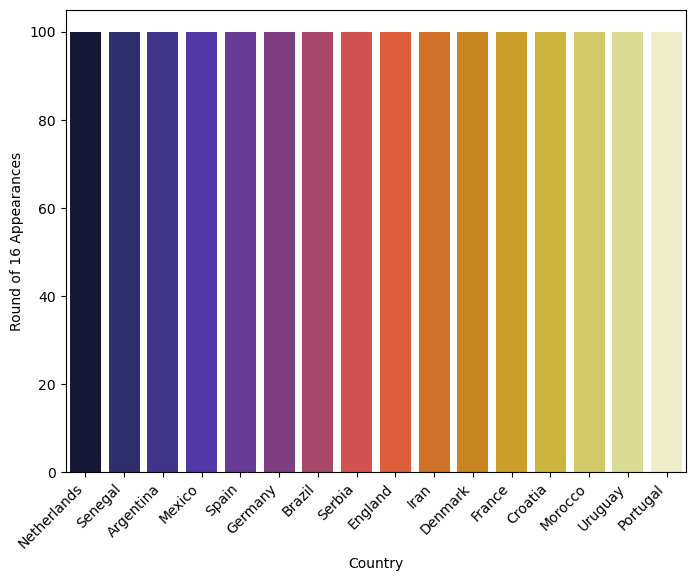

In [677]:
x = df_ro16['Country'].values
y = df_ro16['Appearances'].values
fig, ax = plt.subplots(figsize=(8,6))
plt.xticks(rotation=45, ha='right')
sns.barplot(x,y,ax=ax)
plt.ylabel('Round of 16 Appearances')
plt.xlabel('Country')
plt.savefig('LogReg2022Ro16', bbox_inches = "tight")
plt.show()

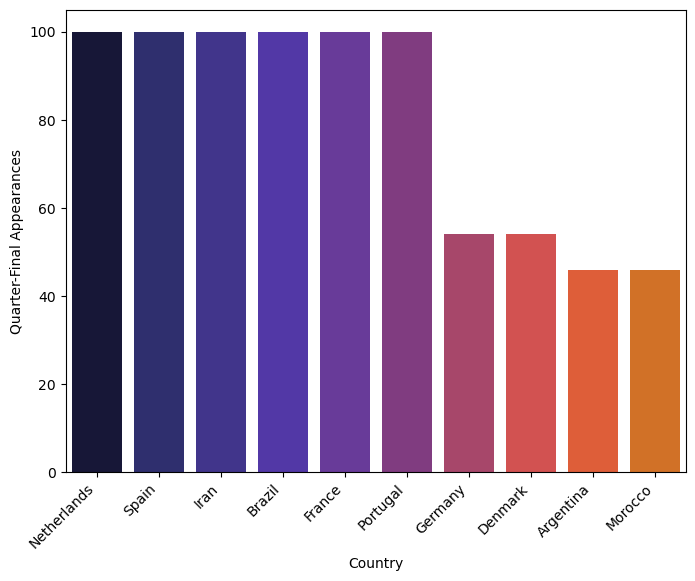

In [678]:
x = df_quarter['Country'].values
y = df_quarter['Appearances'].values
fig, ax = plt.subplots(figsize=(8,6))
plt.xticks(rotation=45, ha='right')
sns.barplot(x,y,ax=ax)
plt.ylabel('Quarter-Final Appearances')
plt.xlabel('Country')
plt.savefig('LogReg2022QF', bbox_inches = "tight")
plt.show()

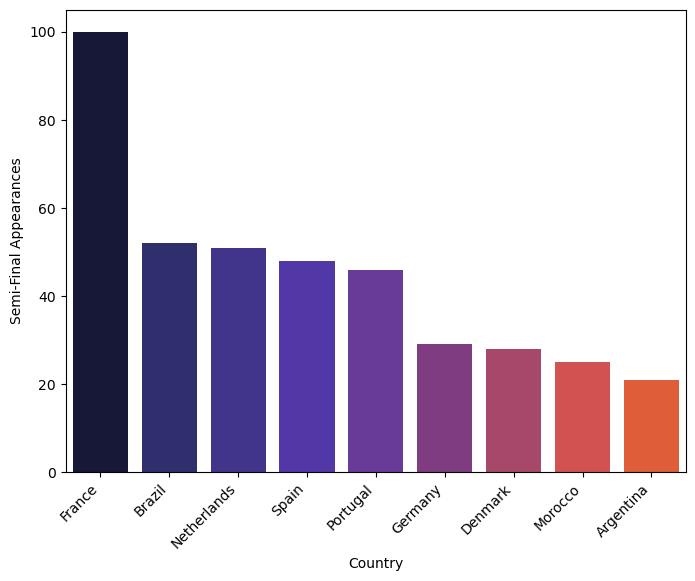

In [679]:
x = df_semi['Country'].values
y = df_semi['Appearances'].values
fig, ax = plt.subplots(figsize=(8,6))
plt.xticks(rotation=45, ha='right')
sns.barplot(x,y,ax=ax)
plt.ylabel('Semi-Final Appearances')
plt.xlabel('Country')
plt.savefig('LogReg2022SF', bbox_inches = "tight")
plt.show()

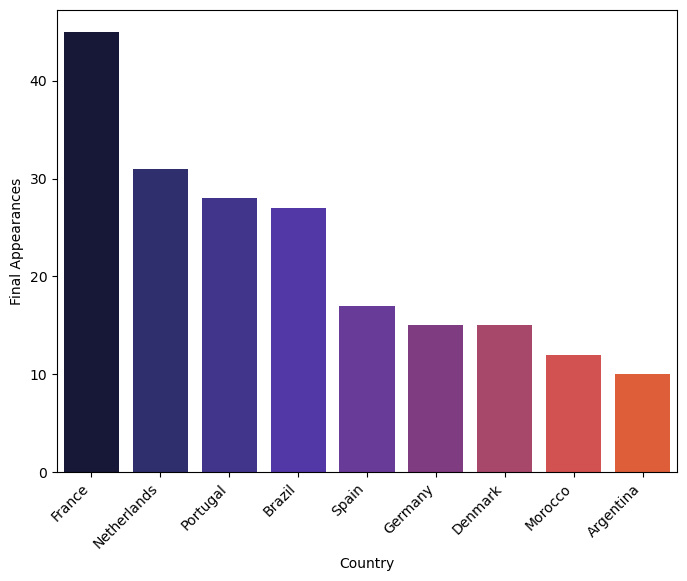

In [680]:
x = df_final['Country'].values
y = df_final['Appearances'].values
fig, ax = plt.subplots(figsize=(8,6))
plt.xticks(rotation=45, ha='right')
sns.barplot(x,y,ax=ax)
plt.ylabel('Final Appearances')
plt.xlabel('Country')
plt.savefig('LogReg2022Final', bbox_inches = "tight")
plt.show()

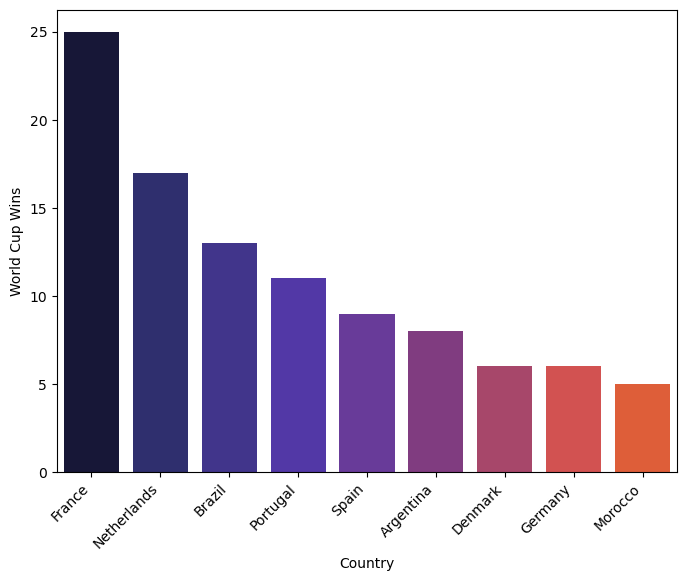

In [681]:
x = df_winner['Country'].values
y = df_winner['Appearances'].values
fig, ax = plt.subplots(figsize=(8,6))
plt.xticks(rotation=45, ha='right')
sns.barplot(x,y,ax=ax)
plt.ylabel('World Cup Wins')
plt.xlabel('Country')
plt.savefig('LogReg2022Winner', bbox_inches = "tight")
plt.show()